In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.simplefilter('ignore')



In [2]:
DATA_DIR = 'content'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

client_train = pd.read_csv(f'{TRAIN_DIR}/client_train.csv', low_memory=False)
invoice_train = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv', low_memory=False)


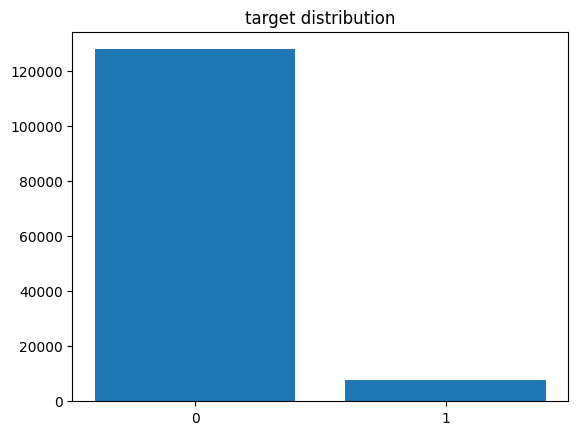

In [3]:
ds = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=ds.index, height=ds.values, tick_label =[0,1])
plt.title('target distribution')
plt.show()


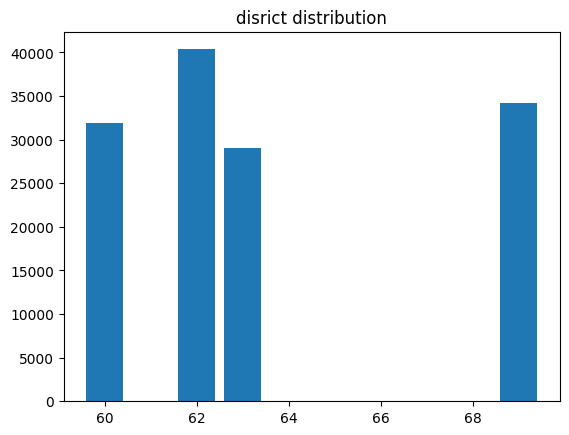

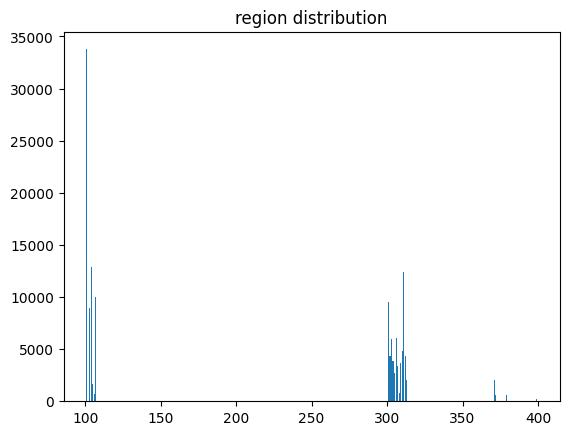

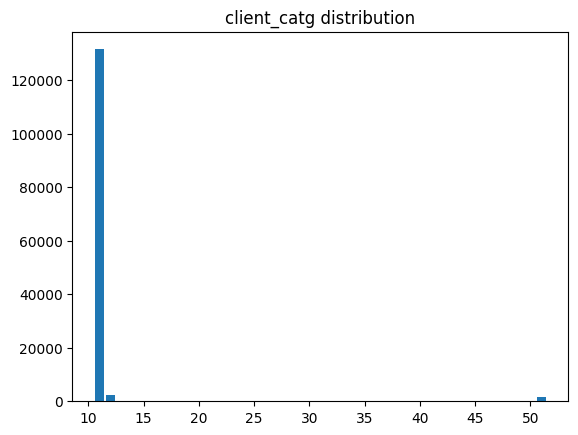

In [4]:
for col in ['disrict','region','client_catg']:
    ds = client_train.groupby([col])['client_id'].count()
    plt.bar(x=ds.index, height=ds.values)
    plt.title(col+' distribution')
    plt.show()


In [5]:
print('Number of missing rows in invoice_train:',invoice_train.isna().sum().sum())

print('Number of missing rows in client_train:',client_train.isna().sum().sum())



Number of missing rows in invoice_train: 0
Number of missing rows in client_train: 0


In [6]:
print('Number of unique values in invoice_train:')
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")


Number of unique values in invoice_train:
client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [4]:
def feature_change(cl, inv):

    cl['client_catg'] = cl['client_catg'].astype('int')
    cl['disrict'] = cl['disrict'].astype('int')
    cl['region'] = cl['region'].astype('int')
    cl['region_group'] = cl['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200)
    cl['creation_date'] = pd.to_datetime(cl['creation_date'])
    
    cl['coop_time'] = (2019 - cl['creation_date'].dt.year)*12 - cl['creation_date'].dt.month

    inv['counter_type'] = inv['counter_type'].map({"ELEC":1,"GAZ":0})
    inv['counter_statue'] = inv['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5})
    
    inv['invoice_date'] = pd.to_datetime(inv['invoice_date'], dayfirst=True)
    inv['invoice_month'] = inv['invoice_date'].dt.month
    inv['invoice_year'] = inv['invoice_date'].dt.year
    inv['is_weekday'] = ((pd.DatetimeIndex(inv.invoice_date).dayofweek) // 5 == 1).astype(float)
    inv['delta_index'] = inv['new_index'] - inv['old_index']
    
    return cl, inv

In [5]:
client_train1, invoice_train1 = feature_change(client_train, invoice_train)

In [6]:
def agg_feature(invoice, client_df, agg_stat):
    
    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['mean','std','min','max'])
    
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')
    
    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')
    
    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')
    
    full_df['invoice_per_cooperation'] = full_df['transactions_count'] / full_df['coop_time']
    
    return full_df

In [7]:
agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'invoice_month',
 'invoice_year',
 'delta_index'
]

train_df1 = agg_feature(invoice_train1, client_train1, agg_stat_columns)

In [8]:
def new_features(df):
    
    for col in agg_stat_columns:
        df[col+'_range'] = df[col+'_max'] - df[col+'_min']
        df[col+'_max_mean'] = df[col+'_max']/df[col+'_mean']
    
    return df

In [9]:
train_df2 = new_features(train_df1)

In [10]:
print('Initial number of columns: ', len(client_train.columns)+len(invoice_train.columns))
print('Number of columns now: ', len(train_df2.columns))



Initial number of columns:  29
Number of columns now:  111


In [11]:
def drop(df):

    col_drop = ['client_id', 'creation_date']
    for col in col_drop:
        df.drop([col], axis=1, inplace=True)
    return df

In [12]:
train_df = drop(train_df2)

In [13]:
y = train_df['target']
X = train_df.drop('target',axis=1)

feature_name = X.columns.tolist()

In [14]:
drop_col=['reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max','counter_type_range',
          'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean']

X = X.drop(drop_col, axis=1)

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, classification_report
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# bin numerical data, scale data, encode data
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler, OneHotEncoder  
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

# XGBoost model
#-------------------------------------------------------
import xgboost as xgb
from xgboost import XGBClassifier

# LGBM model
#-------------------------------------------------------
import lightgbm
from lightgbm import LGBMClassifier

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=777, test_size=0.2)

In [ ]:
features_knn_only = X_train.columns[X_train.isna().any()]


pipeline_knn                = Pipeline([
                                        ( 'KNN_impute',      KNNImputer()     ),   
                                        ])

my_column_transfomer        = ColumnTransformer([
                                                ( 'KNNimpute',                   pipeline_knn,                   features_knn_only            ),
                                                ])

my_column_transfomer.fit(X_train)
X_imputed = my_column_transfomer.transform(X_train)


In [38]:
features_knn_only = X_train.columns[X_train.isna().any()]


pipeline_knn                = Pipeline([
                                        ( 'KNN_impute',      KNNImputer()     ),   
                                        ])

my_column_transfomer        = ColumnTransformer([
                                                ( 'KNNimpute',                   pipeline_knn,                   features_knn_only            ),
                                                ])


pipeline_model              = Pipeline([
                                       ('ct',      my_column_transfomer    ),                                                                  
                                       ('xgb_model', xgb.XGBClassifier()   ),
                                       ])

pipeline_model.fit(X_train, y_train)

y_pred = pipeline_model.predict(X_test)

MemoryError: Unable to allocate 1.00 GiB for an array with shape (1238, 108394) and data type float64

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()


In [22]:
xgb_model = xgb.XGBClassifier()
#lgbm_model = LGBMClassifier()

xgb_model.fit(X_train, y_train)
#lgbm_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
#y_pred = lgbm_model.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

XGBoostError: [19:15:12] ../src/data/data.cc:1104: Check failed: valid: Input data contains `inf` or `nan`
Stack trace:
  [bt] (0) /home/karol/.venv/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x20b233) [0x7fc96ab50233]
  [bt] (1) /home/karol/.venv/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x22cea1) [0x7fc96ab71ea1]
  [bt] (2) /home/karol/.venv/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x27e706) [0x7fc96abc3706]
  [bt] (3) /home/karol/.venv/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x220265) [0x7fc96ab65265]
  [bt] (4) /home/karol/.venv/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(XGDMatrixCreateFromDense+0x329) [0x7fc96aa8ff09]
  [bt] (5) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7fc9e85cfdae]
  [bt] (6) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x22f) [0x7fc9e85cf71f]
  [bt] (7) /home/karol/.pyenv/versions/3.11.3/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x13d46) [0x7fc9e87e5d46]
  [bt] (8) /home/karol/.pyenv/versions/3.11.3/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0xd359) [0x7fc9e87df359]



[LightGBM] [Info] Number of positive: 6053, number of negative: 102341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20085
[LightGBM] [Info] Number of data points in the train set: 108394, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055843 -> initscore=-2.827756
[LightGBM] [Info] Start training from score -2.827756


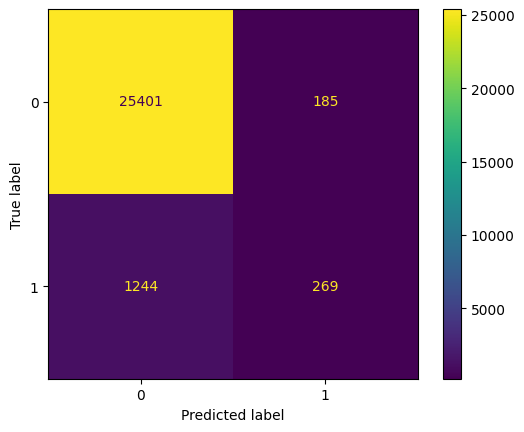

In [21]:
lgbm_model = LGBMClassifier()

lgbm_model.fit(X_train, y_train)

y_pred = lgbm_model.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()